### Working with EPA AirNow (API calls for Air Quality Data)
 
 
##### Authors(s): Maurice Roots | mroots@umbc.edu
##### Last Update: 2025-08-15

---
#### Function Space

In [21]:
# Importing Packages

from collections import namedtuple
from urllib.parse import urljoin, urlencode, urlparse, urlunparse
from datetime import datetime, timedelta, UTC
import keyring 
import requests 
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [14]:
def build_url(api_key, **kwargs):
    base_url = "https://www.airnowapi.org/aq/data/"

    startDate = kwargs.get("startDate", (datetime.now(UTC) - timedelta(days=1)).strftime("%Y-%m-%dT%H"))
    endDate = kwargs.get("endDate", (datetime.now(UTC)).strftime("%Y-%m-%dT%H"))
    parameters = kwargs.get("parameters", ["OZONE", "PM25", "PM10", "CO", "NO2", "SO2"])
    BBOX = kwargs.get("BBOX", ["-80.655479", "35.574398", "-72.086143", "41.415693"])

    query_params = {
        'startDate': startDate,
        'endDate': endDate,
        'parameters': ','.join(parameters),
        'BBOX': ','.join(BBOX),
        'dataType': kwargs.get("dataType", 'B'),
        'format': kwargs.get("format", 'application/json'),
        'verbose': kwargs.get("verbose", "1"),
        'monitorType': kwargs.get("monitorType", "0"),
        'includerawconcentrations': "1",
        'API_KEY': api_key
    }

    # Manually build query string to avoid encoding commas
    query_string = '&'.join(f"{key}={value}" for key, value in query_params.items())
    return f"{base_url}?{query_string}"


def pull_EPA_data(**kwargs): 
    api_key = keyring.get_password("EPA_API_KEY", "")
    if not api_key: 
        api_key = input("EPA AIRNOW API KEY: ")
        keyring.set_password("EPA_API_KEY", "", api_key)

    url = build_url(api_key, **kwargs)
    response = requests.get(url)
    return response

def _nest(df: pd.DataFrame, metadata: pd.DataFrame, **kwargs):
    keep_cols = kwargs.get(
        "data_cols", 
        ["UTC", "Value", "RawConcentration", "AQI", "Category", "Latitude", "Longitude", "Parameter"]
    )
    
    df = df[[c for c in df.columns if c in keep_cols]].copy()

    metadata_small = metadata[["Latitude", "Longitude", "id"]].drop_duplicates()
    df = df.merge(metadata_small, on=["Latitude", "Longitude"], how="left")
    df.drop(columns=["Latitude", "Longitude"], inplace=True)

    df["UTC"] = pd.to_datetime(df["UTC"])
    df.set_index("UTC", inplace=True)
    

    data = {
        parameter: 
                {
                    id_: group.drop(columns=["Parameter", "id"]) 
                    for id_, group in df_param.groupby("id")
                }
        for parameter, df_param in df.groupby("Parameter")
        }

    return data

def _metadata(df: pd.DataFrame, **kwargs): 
    data_columns = ["UTC", "Value", "RawConcentration", "AQI", "Category"]
    metadata = df.copy().drop(
        columns=data_columns
        ).drop_duplicates(keep="first").reset_index(drop=True)
    
    parameters = [
        metadata[["Parameter", "Unit"]][metadata["FullAQSCode"] == site].to_dict(orient="list")
        for site in metadata["FullAQSCode"].unique()
    ]
    
    metadata = metadata.copy().drop(
        columns=["Parameter", "Unit"]
        ).drop_duplicates(keep="first").reset_index(drop=True)
    
    metadata["Parameters"] = parameters
    metadata["id"] = metadata.index
    return metadata
    
class DictOfDataFrames:
    def __init__(self, dfs_dict):
        self._dfs = dfs_dict  # internal dict of DataFrames

    def __getattr__(self, attr):
        # Called when you do df.some_method()
        def wrapper(*args, **kwargs):
            # Apply the method to each DataFrame in the dict
            new_dfs = {
                k: getattr(v, attr)(*args, **kwargs)
                for k, v in self._dfs.items()
            }
            # If result is a DataFrame, wrap it again
            # Some pandas methods return DataFrames (resample returns Resampler)
            # We'll wrap DataFrames, leave others as-is
            if all(isinstance(v, pd.DataFrame) or isinstance(v, pd.core.resample.Resampler) for v in new_dfs.values()):
                return DictOfDataFrames(new_dfs)
            else:
                return new_dfs
        return wrapper

    def __getitem__(self, key):
        return self._dfs[key]

    def __repr__(self):
        return repr(self._dfs)

---
#### Analytics Space

__Grabbing all EPA AirNow data for:__ 
- bbox = ["-80.655479", "35.574398", "-72.086143", "41.415693"] (e.g., Mid-Atlantic)
- parameters = ["OZONE", "PM25", "PM10", "CO", "NO2", "SO2"] (i.e., pollutants)
- date_range = (2025-01-01, 2025-08-01) 

``` python
date_range = [t.strftime("%Y-%m-%dT%H") for t in pd.date_range(start = "2025-01-01", end="2025-08-01", freq="1d")]

temp = [
    pd.DataFrame(
        pull_EPA_data(
            startDate=date_range[i-1], 
            endDate=date_range[i]
            ).json()
        )
    for i in range(1, len(date_range))
    ]

airnow = pd.concat(temp)

metadata = _metadata(airnow)
data = _nest(airnow, metadata)

```

```python
import pickle 
with open(r"G:\Research\CoURAGE\data\EPA_AirNow_data.pickle", "wb") as f: 
    pickle.dump(data, f)
    
with open(r"G:\Research\CoURAGE\data\EPA_AirNow_metadata.pickle", "wb") as f: 
    pickle.dump(metadata, f)
'''

```python 
with open(r"G:\Research\CoURAGE\data\EPA_AirNow_data.pickle", "rb") as f:
    data = pickle.load(f)
    
with open(r"G:\Research\CoURAGE\data\EPA_AirNow_metadata.pickle", "rb") as f:
    metadata = pickle.load(f)
```

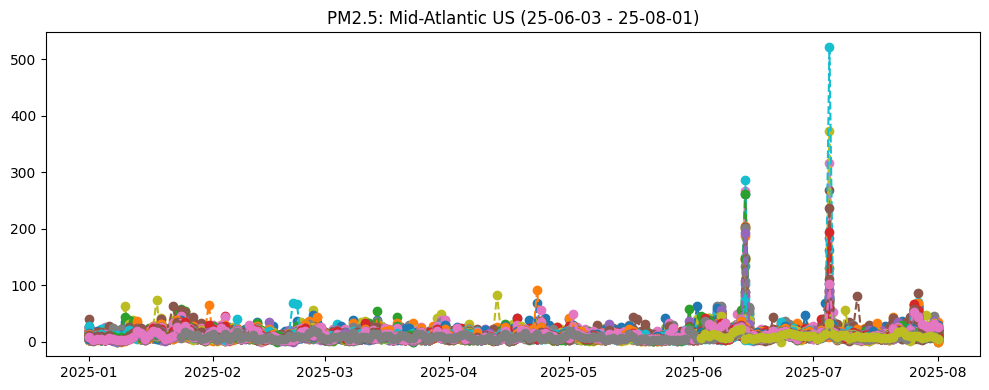

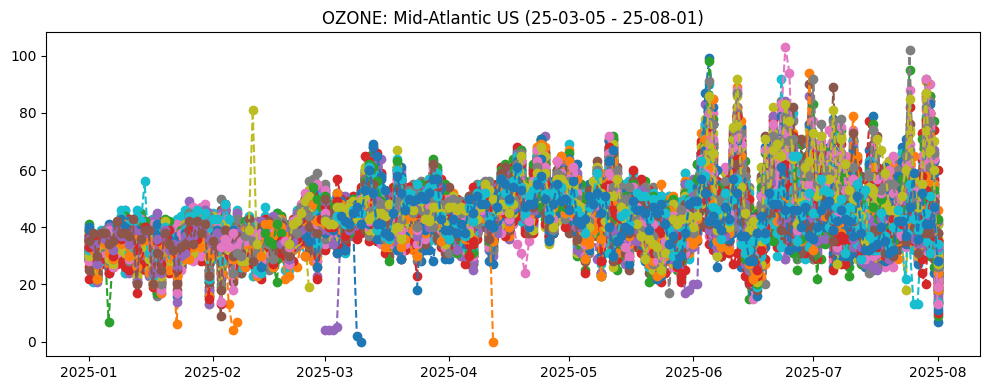

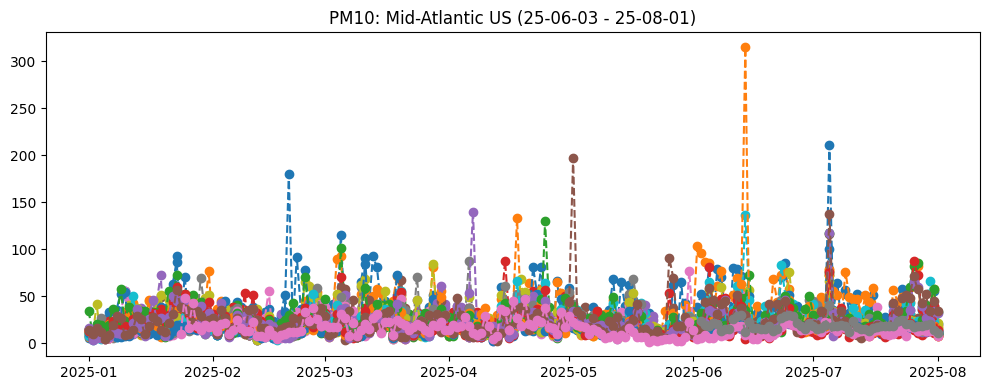

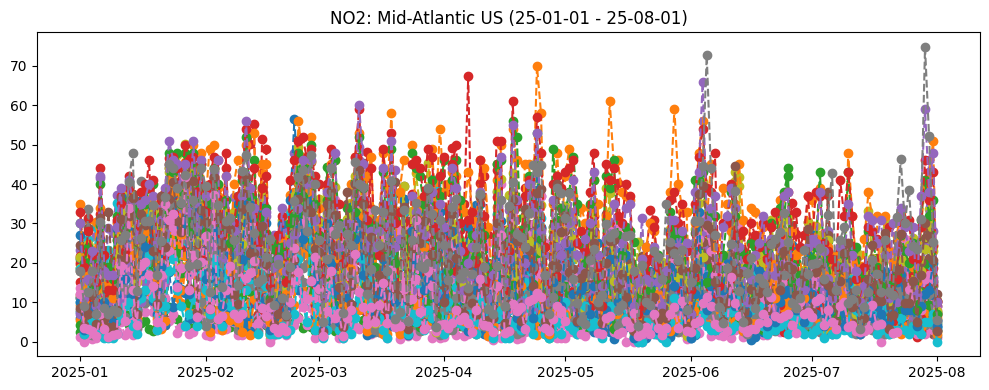

In [27]:
for key in ["PM2.5", "OZONE", "PM10", "NO2"]: 
    fig, ax = plt.subplots(figsize=(10,4), layout="tight")
    for site in data[key].keys():
        Y = data[key][site].copy().resample("1d").max()
        X, Y = Y.index, Y["Value"].to_numpy()
        Y[Y < 0] = np.nan 
        ax.plot(X, Y, "--o", label=site)
    plt.title(f"{key}: Mid-Atlantic US ({X[0].strftime('%y-%m-%d')} - {X[-1].strftime('%y-%m-%d')})")

https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/raster/HYP_HR_SR_W_DR.zip

In [ ]:
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
# import matplotlib.pyplot as plt

In [ ]:
# for x in test.index.unique():
#     df = test.loc[x]
    
#     fig = plt.figure(figsize=(10, 8))
#     ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

#     # ax.stock_img()

#     ax.add_feature(cfeature.COASTLINE)
#     ax.add_feature(cfeature.BORDERS, linestyle=':')
#     ax.add_feature(cfeature.LAND)
#     ax.add_feature(cfeature.OCEAN)
    
#     eh = ax.scatter(df['Longitude'], df['Latitude'], c=df["Value"], transform=ccrs.PlateCarree(),
#                marker='o', s=50, cmap='jet', vmin=0, vmax=20)
#     fig.colorbar(eh, ax=ax)
#     ax.set_title(f'EPA AirNow PM2.5: {x}')
    
#     gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#                   linewidth=2, color='gray', alpha=0.5, linestyle='--')
#     gl.xlabels_top = False
#     gl.ylabels_right = False
    
#     plt.show()